In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm
from torchvision import models
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

proj_dim = 128
prototypes_per_class = 2
sigma = 0.5
lambda_div = 0.01
sigma_div = 0.5


In [1]:

class AffinityLoss(nn.Module):
    """
    Affinity Loss (prototype-based, Gaussian affinity).
    - Each class has M prototypes in R^D (learned).
    - Class score = logsumexp over affinities to that class's prototypes.
    - Loss = CrossEntropy over class scores (+ optional diversity penalty).

    Args:
        num_classes:      C
        feat_dim:         D
        prototypes_per_class: M
        sigma:            Gaussian sigma for affinity (in feature space units)
        lambda_div:       weight for diversity regularizer (intra-class prototype repulsion)
        sigma_div:        sigma for diversity penalty (distance scale)
        device:           torch device
    """
    def __init__(self, num_classes:int, feat_dim:int, prototypes_per_class:int=2,
                 sigma:float=0.5, lambda_div:float=0.0, sigma_div:float=0.5, device="cpu"):
        super().__init__()
        self.C = num_classes
        self.D = feat_dim
        self.M = prototypes_per_class
        self.sigma2 = sigma * sigma
        self.lambda_div = lambda_div
        self.sigma_div2 = sigma_div * sigma_div

        # (C, M, D)
        self.prototypes = nn.Parameter(torch.randn(self.C, self.M, self.D, device=device) * 0.01)

    def forward(self, feats: torch.Tensor, labels: torch.Tensor):
        """
        feats:  (N, D)
        labels: (N,) long
        returns: (loss, class_logits) where class_logits is (N, C)
        """
        # distances to prototypes: (N, C, M)
        # Expand and compute squared L2
        N = feats.size(0)
        x = feats.unsqueeze(1).unsqueeze(2)                  # (N,1,1,D)
        p = self.prototypes.unsqueeze(0)                     # (1,C,M,D)
        d2 = torch.sum((x - p) ** 2, dim=-1)                 # (N,C,M)

        # Gaussian affinities per prototype
        # a_{c,m} = exp(-d2 / (2*sigma^2))
        a = torch.exp(-d2 / (2.0 * self.sigma2))             # (N,C,M)

        # Class score = logsumexp over prototypes per class
        # logits_c = log( sum_m a_{c,m} )
        class_logits = torch.log(torch.clamp(a.sum(dim=2), min=1e-12))  # (N,C)

        # Cross-entropy over classes
        ce = F.cross_entropy(class_logits, labels)

        # Diversity regularizer (optional): repel same-class prototypes
        div = torch.tensor(0.0, device=feats.device)
        if self.lambda_div > 0:
            # pairwise distances within each class: (C, M, M)
            pp = self.prototypes  # (C,M,D)
            # squared distances between all pairs m1,m2 within class
            diff = pp.unsqueeze(2) - pp.unsqueeze(1)         # (C,M,M,D)
            d2_pp = (diff ** 2).sum(dim=-1)                  # (C,M,M)
            # exclude diagonal; encourage larger distances -> penalize high affinity
            mask = 1 - torch.eye(self.M, device=feats.device).unsqueeze(0)  # (1,M,M)
            repulsion = torch.exp(-d2_pp / (2.0 * self.sigma_div2)) * mask
            div = repulsion.sum() / (self.C * self.M * (self.M - 1) + 1e-6)

        loss = ce + self.lambda_div * div
        return loss, class_logits


In [2]:

# Instantiate AFTER you know num_classes and proj_dim
# affinity = AffinityLoss(num_classes, proj_dim, prototypes_per_class, sigma, lambda_div, sigma_div, device)

def train_one_epoch(features_fn, feat_proj, affinity, optimizer, loader, device):
    feat_proj.train()
    running = 0.0
    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():                      # backbone frozen
                f_backbone = features_fn(imgs)        # (N, D_backbone)
            f = feat_proj(f_backbone)                 # (N, D)
            loss, _ = affinity(f, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def evaluate_epoch(features_fn, feat_proj, affinity, loader, device):
    feat_proj.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        f = feat_proj(features_fn(imgs))             # (N, D)
        loss, class_logits = affinity(f, y)
        total_loss += loss.item() * imgs.size(0)

        preds = class_logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


In [4]:

# Build & freeze
vit = models.vit_b_16(pretrained=True).to(device)
for p in vit.parameters(): p.requires_grad = False
vit.eval()

# feature dim before head:
feat_dim_backbone = vit.heads.head.in_features  # 768 for vit_b_16
vit.heads.head = nn.Identity()  # we won't use its head

# helper to get CLS feature (torchvision ViT)
def vit_cls_features(tv_vit, x):
    x = tv_vit._process_input(x)
    n = x.shape[0]
    cls_tok = tv_vit.class_token.expand(n, -1, -1)
    x = torch.cat((cls_tok, x), dim=1)
    x = tv_vit.encoder(x)
    return x[:, 0]  # (N, feat_dim_backbone)

def features_fn_vit(x):
    return vit_cls_features(vit, x)



# Use ImageNet normalization for pretrained ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


# projection + loss + optimizer
feat_proj = nn.Linear(feat_dim_backbone, proj_dim).to(device)
affinity = AffinityLoss(len(train_dataset.classes), proj_dim,
                        prototypes_per_class, sigma, lambda_div, sigma_div, device).to(device)

optimizer = optim.Adam([
    {"params": feat_proj.parameters(), "lr": 1e-3},
    {"params": affinity.parameters(), "lr": 5e-4},  # prototypes
])

# train/eval
for ep in range(10):
    tr = train_one_epoch(features_fn_vit, feat_proj, affinity, optimizer, train_loader, device)
    acc, vl = evaluate_epoch(features_fn_vit, feat_proj, affinity, test_loader, device)
    print(f"[ViT] epoch {ep+1}: train {tr:.4f} | val {vl:.4f} | acc {acc:.3f}")


[ViT] epoch 1: train 0.7023 | val 0.7019 | acc 0.724


[ViT] epoch 2: train 0.7013 | val 0.7003 | acc 0.724


[ViT] epoch 3: train 0.6993 | val 0.6981 | acc 0.724


[ViT] epoch 4: train 0.6972 | val 0.6962 | acc 0.724


[ViT] epoch 5: train 0.6955 | val 0.6949 | acc 0.724


[ViT] epoch 6: train 0.6946 | val 0.6942 | acc 0.724


[ViT] epoch 7: train 0.6940 | val 0.6939 | acc 0.724


[ViT] epoch 8: train 0.6938 | val 0.6937 | acc 0.724


[ViT] epoch 9: train 0.6936 | val 0.6935 | acc 0.724


[ViT] epoch 10: train 0.6935 | val 0.6934 | acc 0.724


In [12]:
@torch.no_grad()
def evaluate_epoch(features_fn, feat_proj, affinity, loader, device):
    feat_proj.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        f = feat_proj(features_fn(imgs))             # (N, D)
        loss, class_logits = affinity(f, y)

        preds = class_logits.argmax(dim=1)

        all_labels.extend(y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative     0.7235    1.0000    0.8396       157
    Positive     0.0000    0.0000    0.0000        60

    accuracy                         0.7235       217
   macro avg     0.3618    0.5000    0.4198       217
weighted avg     0.5235    0.7235    0.6074       217

Confusion Matrix:
 [[157   0]
 [ 60   0]]


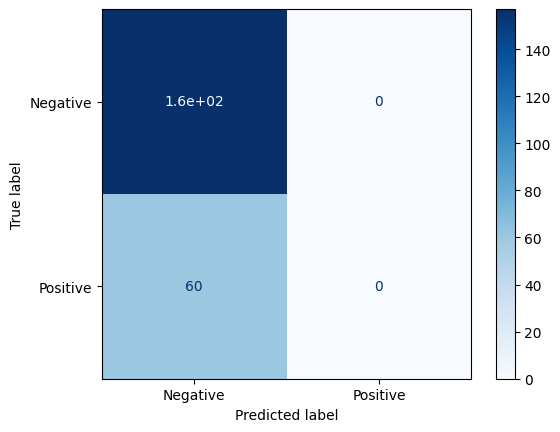

In [13]:

# ---- Generate reports ----
labels, preds = evaluate_epoch(features_fn_vit, feat_proj, affinity, test_loader, device)

# Classification report (precision, recall, f1)
print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

# Optional: visualize it
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
